# Day 64: Generative Adversarial Networks (GANs)

## Introduction

Generative Adversarial Networks (GANs) represent one of the most exciting developments in deep learning over the past decade. Introduced by Ian Goodfellow and his colleagues in 2014, GANs have revolutionized the field of generative modeling by enabling machines to create remarkably realistic synthetic data.

Unlike traditional supervised learning models that learn to map inputs to outputs, GANs learn to generate entirely new data samples that resemble a training dataset. This capability has led to breakthrough applications in image generation, style transfer, data augmentation, and even creating realistic human faces that don't actually exist.

The key innovation of GANs lies in their adversarial training process: two neural networks compete against each other in a game-theoretic framework. One network (the Generator) tries to create fake data that looks real, while the other network (the Discriminator) tries to distinguish between real and fake data. Through this competition, both networks improve, ultimately resulting in a generator capable of producing highly realistic synthetic samples.

### Learning Objectives

By the end of this lesson, you will be able to:

- Understand the architecture and components of Generative Adversarial Networks
- Explain the adversarial training process and minimax game theory
- Implement a basic GAN using Python and deep learning frameworks
- Analyze generator and discriminator loss functions
- Train a GAN to generate synthetic data and visualize the results
- Recognize common challenges in GAN training and potential solutions

## Theoretical Foundations

### What are Generative Models?

Before diving into GANs specifically, let's understand generative models in general. In machine learning, we distinguish between two main types of models:

1. **Discriminative Models**: These learn the boundary between different classes. They model the conditional probability $P(y|x)$ - the probability of a label $y$ given input features $x$. Examples include logistic regression, support vector machines, and most classification neural networks.

2. **Generative Models**: These learn the underlying distribution of the data itself. They model the joint probability $P(x, y)$ or just $P(x)$ for unlabeled data. Generative models can create new data samples by sampling from the learned distribution.

GANs fall into the category of generative models, specifically designed to learn complex, high-dimensional data distributions (like images) and generate new samples from those distributions.

### GAN Architecture: The Two Networks

A GAN consists of two neural networks that work in opposition:

**1. The Generator (G)**
- Takes random noise as input (typically sampled from a normal or uniform distribution)
- Transforms this noise into synthetic data samples
- Goal: Generate fake samples that are indistinguishable from real data
- Can be thought of as a "counterfeiter" trying to create fake currency

**2. The Discriminator (D)**
- Takes either real data or generated (fake) data as input
- Outputs a probability: how likely the input is to be real (vs. fake)
- Goal: Correctly classify samples as real or fake
- Can be thought of as a "detective" trying to identify fake currency

### The Adversarial Training Process

The training process alternates between updating the discriminator and the generator:

1. **Train the Discriminator**: 
   - Show it real samples from the training data (label as "real")
   - Generate fake samples using the current generator (label as "fake")
   - Update discriminator weights to better distinguish real from fake

2. **Train the Generator**:
   - Generate fake samples
   - Pass them through the discriminator
   - Update generator weights to produce samples that fool the discriminator

This adversarial process continues until we reach a Nash equilibrium where:
- The generator produces samples indistinguishable from real data
- The discriminator can only guess randomly (50% accuracy) because the fakes are so good

## Mathematical Foundations

### The Minimax Game

The training of a GAN can be formalized as a minimax game with the following value function:

$$\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]$$

Let's break down this equation:

- $G$: The generator network
- $D$: The discriminator network
- $x$: Real data samples from the true data distribution $p_{data}(x)$
- $z$: Random noise vectors sampled from a prior distribution $p_z(z)$ (often Gaussian)
- $G(z)$: Fake samples generated by the generator from noise $z$
- $D(x)$: Discriminator's estimate of the probability that $x$ is real
- $\mathbb{E}$: Expected value (average over all samples)

**First Term**: $\mathbb{E}_{x \sim p_{data}(x)}[\log D(x)]$
- The expected log-probability that the discriminator correctly identifies real samples
- The discriminator wants to maximize this (output close to 1 for real samples)

**Second Term**: $\mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]$
- The expected log-probability that the discriminator correctly identifies fake samples
- The discriminator wants to maximize this (output close to 0 for fake samples)
- The generator wants to minimize this (fool the discriminator into outputting close to 1)

### Loss Functions

In practice, we train the two networks with separate loss functions:

**Discriminator Loss**:
$$L_D = -\mathbb{E}_{x \sim p_{data}}[\log D(x)] - \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]$$

This is binary cross-entropy loss: the discriminator tries to minimize classification error.

**Generator Loss**:
$$L_G = -\mathbb{E}_{z \sim p_z}[\log D(G(z))]$$

The generator tries to maximize the probability that the discriminator classifies fake samples as real. In practice, instead of minimizing $\log(1 - D(G(z)))$, we often maximize $\log D(G(z))$ as it provides stronger gradients early in training.

### Training Dynamics

The ideal outcome is when:
- $D(x) = 0.5$ for all inputs (discriminator cannot distinguish real from fake)
- $p_g(x) = p_{data}(x)$ (the generator's distribution matches the real data distribution)

However, in practice, GAN training can be unstable and requires careful tuning.

## Python Implementation

Let's implement a simple GAN to generate 2D data points. We'll start with a straightforward example where our "real data" follows a simple Gaussian distribution, and we'll train a GAN to learn to generate similar samples.

### Import Required Libraries

In [1]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

2025-11-09 11:55:48.356680: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-09 11:55:48.357258: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-09 11:55:48.454397: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-11-09 11:55:52.444927: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-09 11:55:52.460361: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


TensorFlow version: 2.20.0
NumPy version: 2.3.4


### Generate Real Data

We'll create a simple 2D dataset following a Gaussian distribution. This will serve as our "real data" that the GAN will learn to replicate.

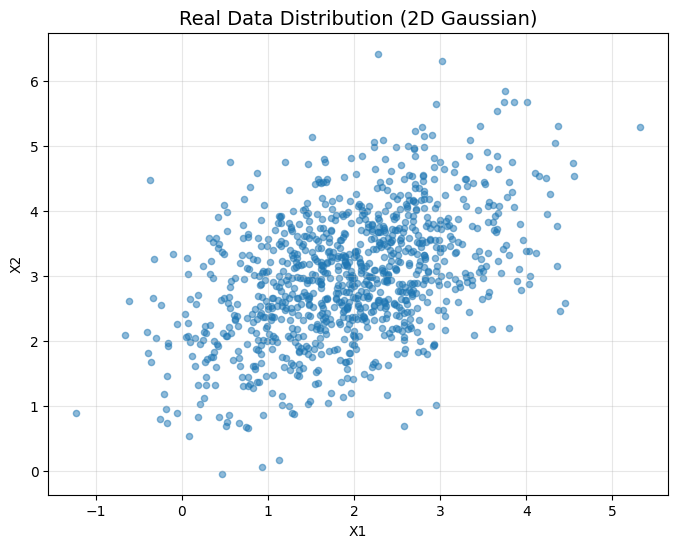

Real data shape: (1000, 2)
Real data mean: [1.94276888 2.99975103]
Real data std: [0.97584697 0.97360838]


In [2]:
def generate_real_samples(n_samples):
    """
    Generate real data samples from a 2D Gaussian distribution.
    
    Args:
        n_samples: Number of samples to generate
    
    Returns:
        Array of shape (n_samples, 2) containing 2D points
    """
    # Generate samples from a 2D Gaussian with mean=[2, 3] and std=1
    mean = np.array([2.0, 3.0])
    cov = np.array([[1.0, 0.5], [0.5, 1.0]])  # Covariance matrix
    samples = np.random.multivariate_normal(mean, cov, n_samples)
    return samples

# Generate and visualize real data
real_data = generate_real_samples(1000)

plt.figure(figsize=(8, 6))
plt.scatter(real_data[:, 0], real_data[:, 1], alpha=0.5, s=20)
plt.title('Real Data Distribution (2D Gaussian)', fontsize=14)
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Real data shape: {real_data.shape}")
print(f"Real data mean: {np.mean(real_data, axis=0)}")
print(f"Real data std: {np.std(real_data, axis=0)}")

### Build the Generator Network

The generator takes random noise as input and produces 2D points that should resemble our real data distribution.

In [3]:
def build_generator(latent_dim=10):
    """
    Build the generator network.
    
    Args:
        latent_dim: Dimension of the input noise vector
    
    Returns:
        Keras model for the generator
    """
    model = models.Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(16, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(2, activation='linear')  # Output 2D points
    ], name='Generator')
    
    return model

# Create generator
latent_dim = 10
generator = build_generator(latent_dim)
generator.summary()

# Test the generator with random noise
test_noise = np.random.normal(0, 1, size=(5, latent_dim))
test_output = generator.predict(test_noise, verbose=0)
print(f"\nGenerator test output shape: {test_output.shape}")
print(f"Sample generated points:\n{test_output[:3]}")

2025-11-09 11:55:53.706921: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)


Generator test output shape: (5, 2)
Sample generated points:
[[-0.34511188 -0.22742817]
 [-0.5558262  -0.3632067 ]
 [-0.43031734 -0.2253384 ]]


### Build the Discriminator Network

The discriminator is a binary classifier that distinguishes between real and fake samples.

In [4]:
def build_discriminator():
    """
    Build the discriminator network.
    
    Returns:
        Keras model for the discriminator
    """
    model = models.Sequential([
        layers.Input(shape=(2,)),  # Input is 2D points
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ], name='Discriminator')
    
    return model

# Create discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', 
                     optimizer=Adam(learning_rate=0.0002),
                     metrics=['accuracy'])
discriminator.summary()

# Test the discriminator
test_real = generate_real_samples(3)
test_pred = discriminator.predict(test_real, verbose=0)
print(f"\nDiscriminator predictions on real samples: {test_pred.flatten()}")

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)


Discriminator predictions on real samples: [0.5578887  0.5923368  0.61838603]


### Build the Complete GAN Model

Now we combine the generator and discriminator into a single GAN model. When training the GAN, we keep the discriminator weights frozen and only update the generator.

In [5]:
def build_gan(generator, discriminator):
    """
    Combine generator and discriminator into GAN model.
    
    Args:
        generator: The generator model
        discriminator: The discriminator model
    
    Returns:
        Combined GAN model
    """
    # Make discriminator non-trainable when training generator
    discriminator.trainable = False
    
    # GAN model: noise -> generator -> discriminator -> classification
    model = models.Sequential([
        generator,
        discriminator
    ], name='GAN')
    
    model.compile(loss='binary_crossentropy',
                 optimizer=Adam(learning_rate=0.0002))
    
    return model

# Create GAN
gan = build_gan(generator, discriminator)
gan.summary()

Model: "GAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Generator (Sequential)          │ (None, 2)              │         1,282 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator (Sequential)      │ (None, 1)              │           769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,051 (8.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 769 (3.00 KB)

### Training the GAN

The training process alternates between training the discriminator and the generator. We'll track the losses to monitor training progress.

In [6]:
def train_gan(gan, generator, discriminator, latent_dim, n_epochs=1000, batch_size=128):
    """
    Train the GAN model.
    
    Args:
        gan: Combined GAN model
        generator: Generator model
        discriminator: Discriminator model
        latent_dim: Dimension of latent space
        n_epochs: Number of training epochs
        batch_size: Batch size for training
    
    Returns:
        Dictionary containing training history
    """
    history = {
        'd_loss_real': [],
        'd_loss_fake': [],
        'd_loss': [],
        'g_loss': [],
        'generated_samples': []  # Store samples at intervals
    }
    
    # Training loop
    for epoch in range(n_epochs):
        # ---------------------
        # Train Discriminator
        # ---------------------
        
        # Generate real samples
        real_samples = generate_real_samples(batch_size)
        real_labels = np.ones((batch_size, 1))  # Label real samples as 1
        
        # Generate fake samples
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        fake_samples = generator.predict(noise, verbose=0)
        fake_labels = np.zeros((batch_size, 1))  # Label fake samples as 0
        
        # Train discriminator on real and fake samples
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
        d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # ---------------------
        # Train Generator
        # ---------------------
        
        # Generate noise for generator training
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        # Labels for generator: we want discriminator to think these are real
        misleading_labels = np.ones((batch_size, 1))
        
        # Train generator (discriminator weights frozen)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, misleading_labels)
        
        # Record history
        history['d_loss_real'].append(d_loss_real[0])
        history['d_loss_fake'].append(d_loss_fake[0])
        history['d_loss'].append(d_loss)
        history['g_loss'].append(g_loss)
        
        # Save generated samples at intervals
        if epoch % 100 == 0:
            noise = np.random.normal(0, 1, size=(500, latent_dim))
            samples = generator.predict(noise, verbose=0)
            history['generated_samples'].append((epoch, samples))
        
        # Print progress
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{n_epochs} - D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")
    
    return history

# Train the GAN
print("Training GAN...\n")
history = train_gan(gan, generator, discriminator, latent_dim, n_epochs=1000, batch_size=128)
print("\nTraining complete!")

Training GAN...



Epoch 0/1000 - D Loss: 0.6095, G Loss: 0.6568


Epoch 100/1000 - D Loss: 0.5738, G Loss: 0.6822


Epoch 200/1000 - D Loss: 0.5124, G Loss: 0.7004


Epoch 300/1000 - D Loss: 0.5135, G Loss: 0.6618


Epoch 400/1000 - D Loss: 0.5550, G Loss: 0.6358


Epoch 500/1000 - D Loss: 0.5892, G Loss: 0.6546


Epoch 600/1000 - D Loss: 0.6093, G Loss: 0.6990


Epoch 700/1000 - D Loss: 0.6216, G Loss: 0.7281


Epoch 800/1000 - D Loss: 0.6329, G Loss: 0.7446


Epoch 900/1000 - D Loss: 0.6400, G Loss: 0.7643



Training complete!


## Visualizing GAN Training Progress

Let's visualize how the generator improves over time and examine the training losses.

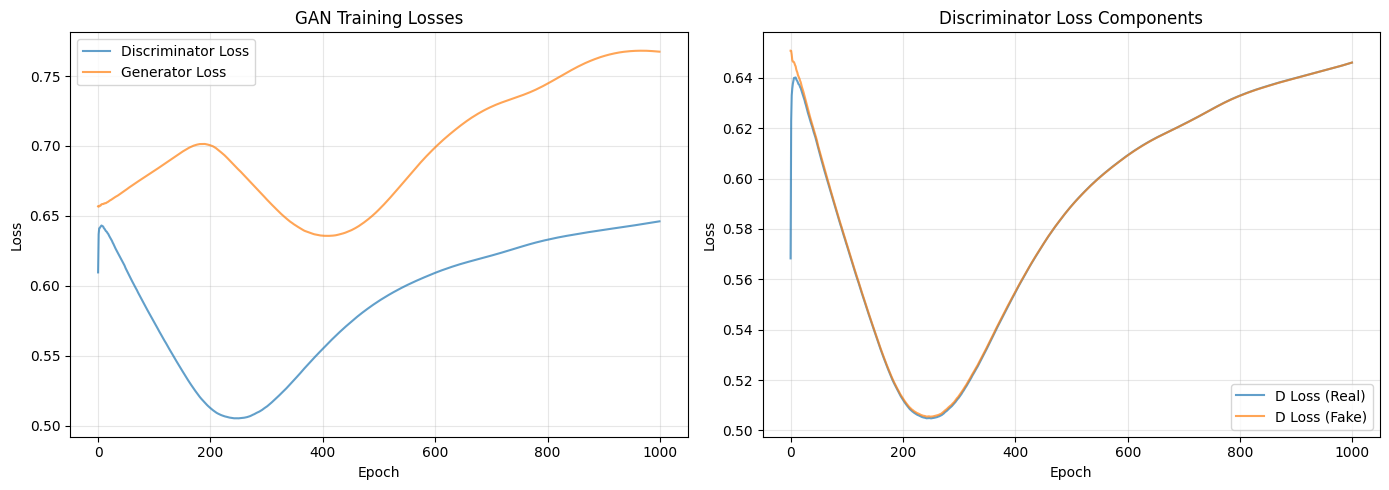

Final Discriminator Loss: 0.6461
Final Generator Loss: 0.7674


In [7]:
# Plot training losses
plt.figure(figsize=(14, 5))

# Discriminator and Generator losses
plt.subplot(1, 2, 1)
plt.plot(history['d_loss'], label='Discriminator Loss', alpha=0.7)
plt.plot(history['g_loss'], label='Generator Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.grid(True, alpha=0.3)

# Discriminator components
plt.subplot(1, 2, 2)
plt.plot(history['d_loss_real'], label='D Loss (Real)', alpha=0.7)
plt.plot(history['d_loss_fake'], label='D Loss (Fake)', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss Components')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Discriminator Loss: {history['d_loss'][-1]:.4f}")
print(f"Final Generator Loss: {history['g_loss'][-1]:.4f}")

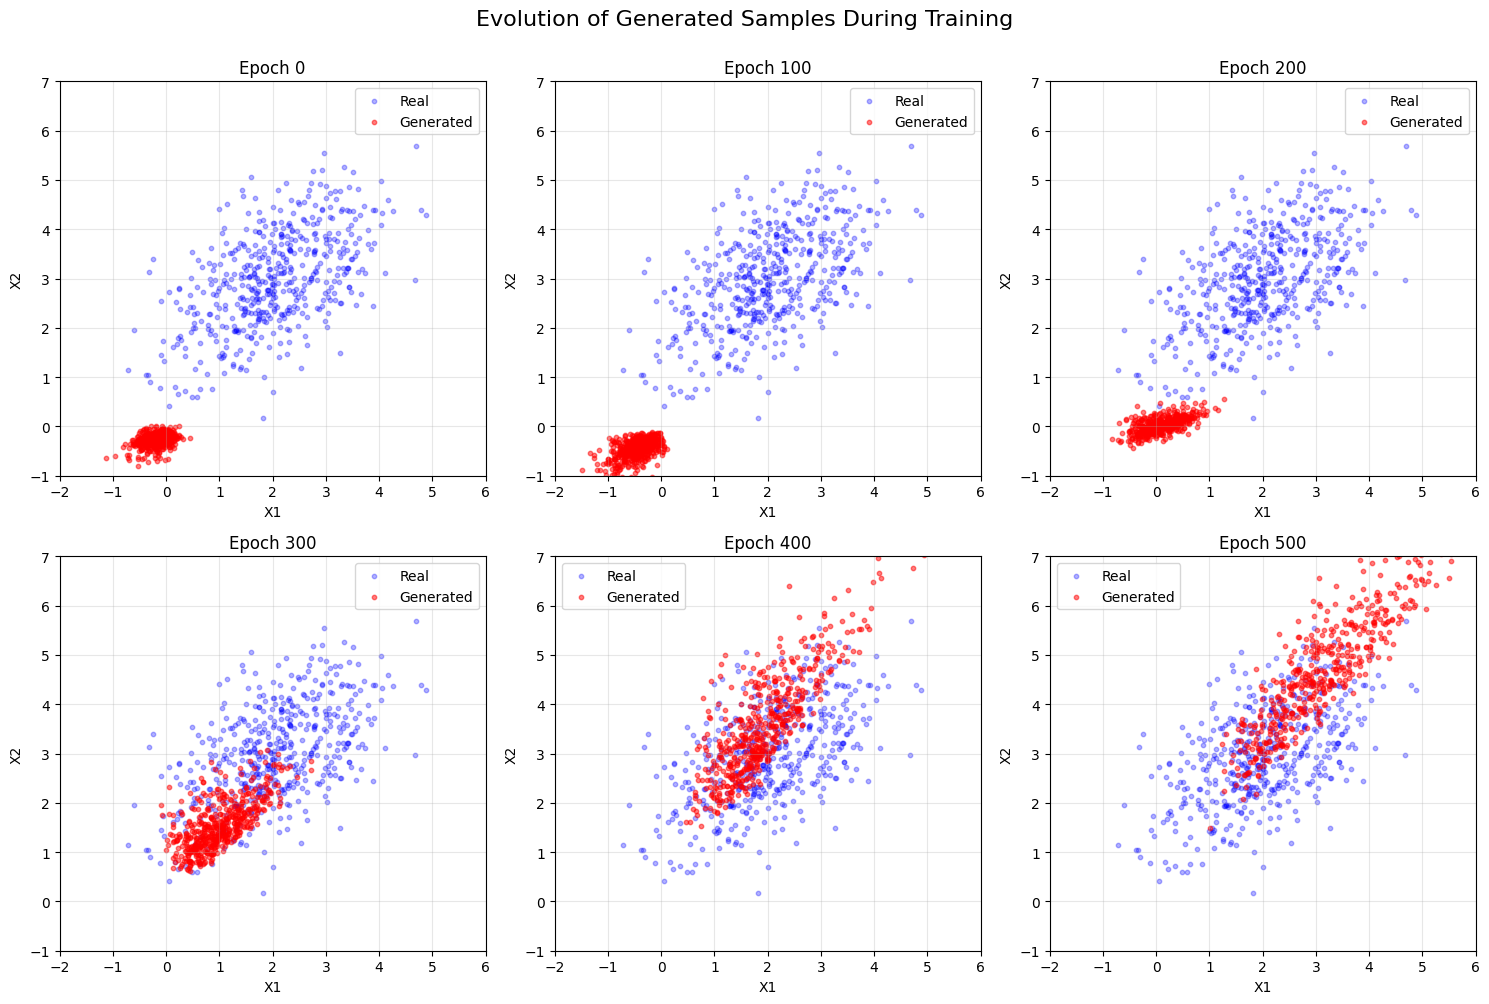

In [8]:
# Visualize generated samples at different training stages
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

real_samples = generate_real_samples(500)

for idx, (epoch, samples) in enumerate(history['generated_samples'][:6]):
    ax = axes[idx]
    ax.scatter(real_samples[:, 0], real_samples[:, 1], 
               alpha=0.3, s=10, c='blue', label='Real')
    ax.scatter(samples[:, 0], samples[:, 1], 
               alpha=0.5, s=10, c='red', label='Generated')
    ax.set_xlim(-2, 6)
    ax.set_ylim(-1, 7)
    ax.set_title(f'Epoch {epoch}')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Evolution of Generated Samples During Training', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

### Final Generated Samples

Let's generate a large batch of samples using our trained generator and compare them with the real data distribution.

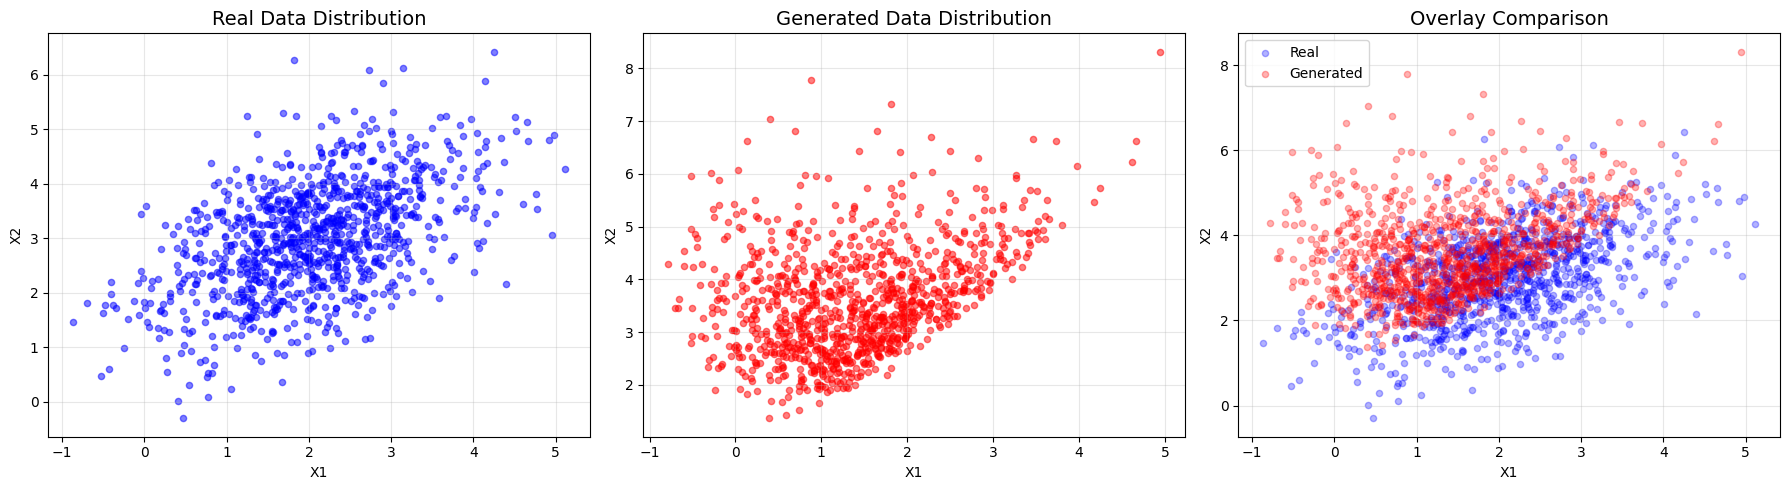

Statistical Comparison:

Real Data:
  Mean: [2.03495126 2.99818492]
  Std:  [0.97969247 1.02029729]

Generated Data:
  Mean: [1.3860837 3.6003008]
  Std:  [0.94225657 1.0179527 ]


In [9]:
# Generate samples using trained generator
n_samples = 1000
noise = np.random.normal(0, 1, size=(n_samples, latent_dim))
generated_samples = generator.predict(noise, verbose=0)
real_samples = generate_real_samples(n_samples)

# Visualize final results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Real data
axes[0].scatter(real_samples[:, 0], real_samples[:, 1], alpha=0.5, s=20, c='blue')
axes[0].set_title('Real Data Distribution', fontsize=14)
axes[0].set_xlabel('X1')
axes[0].set_ylabel('X2')
axes[0].grid(True, alpha=0.3)

# Generated data
axes[1].scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5, s=20, c='red')
axes[1].set_title('Generated Data Distribution', fontsize=14)
axes[1].set_xlabel('X1')
axes[1].set_ylabel('X2')
axes[1].grid(True, alpha=0.3)

# Overlay
axes[2].scatter(real_samples[:, 0], real_samples[:, 1], 
                alpha=0.3, s=20, c='blue', label='Real')
axes[2].scatter(generated_samples[:, 0], generated_samples[:, 1], 
                alpha=0.3, s=20, c='red', label='Generated')
axes[2].set_title('Overlay Comparison', fontsize=14)
axes[2].set_xlabel('X1')
axes[2].set_ylabel('X2')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical comparison
print("Statistical Comparison:")
print(f"\nReal Data:")
print(f"  Mean: {np.mean(real_samples, axis=0)}")
print(f"  Std:  {np.std(real_samples, axis=0)}")
print(f"\nGenerated Data:")
print(f"  Mean: {np.mean(generated_samples, axis=0)}")
print(f"  Std:  {np.std(generated_samples, axis=0)}")

## Common Challenges in GAN Training

Training GANs can be notoriously difficult. Here are some common challenges:

### 1. Mode Collapse

**Problem**: The generator produces limited variety in outputs, repeatedly generating the same or very similar samples.

**Cause**: The generator finds one or a few samples that fool the discriminator and keeps producing those, ignoring the diversity of the real data distribution.

**Solutions**:
- Use mini-batch discrimination
- Try different architectures (e.g., Wasserstein GAN)
- Add noise to discriminator inputs
- Use feature matching

### 2. Vanishing Gradients

**Problem**: When the discriminator becomes too strong, it provides gradients close to zero for the generator.

**Cause**: If the discriminator perfectly separates real and fake samples, the generator receives no useful gradient information to improve.

**Solutions**:
- Use modified loss functions (e.g., Wasserstein loss)
- Balance training between generator and discriminator
- Use label smoothing

### 3. Training Instability

**Problem**: Loss values oscillate wildly, and the quality of generated samples varies drastically between epochs.

**Cause**: The adversarial training process can be unstable as both networks try to outperform each other.

**Solutions**:
- Carefully tune learning rates
- Use techniques like spectral normalization
- Try progressive growing of GANs
- Use batch normalization

### 4. Hyperparameter Sensitivity

**Problem**: Small changes in hyperparameters can dramatically affect training outcomes.

**Solutions**:
- Start with proven architectures and hyperparameters from literature
- Use learning rate schedules
- Experiment with different optimizers (Adam is commonly used)

## Hands-On Exercise: Experimenting with GAN Architecture

Now it's your turn to experiment! Try the following modifications to see how they affect GAN performance:

### Exercise 1: Change the Data Distribution

Modify the `generate_real_samples()` function to create a different distribution:
- Try a mixture of two Gaussians (two clusters)
- Try a circular or ring-shaped distribution
- Observe how well the GAN learns different distributions

### Exercise 2: Adjust Network Architecture

Experiment with the generator and discriminator architectures:
- Add more layers or neurons
- Try different activation functions (LeakyReLU, tanh)
- Add dropout or batch normalization layers

### Exercise 3: Hyperparameter Tuning

Try different hyperparameters:
- Learning rate (try 0.001, 0.0001)
- Batch size (64, 256)
- Latent dimension (5, 20, 50)

### Exercise 4: Training Schedule

Modify the training loop:
- Train discriminator multiple times per generator update
- Add label smoothing (use 0.9 instead of 1.0 for real labels)
- Add noise to discriminator inputs

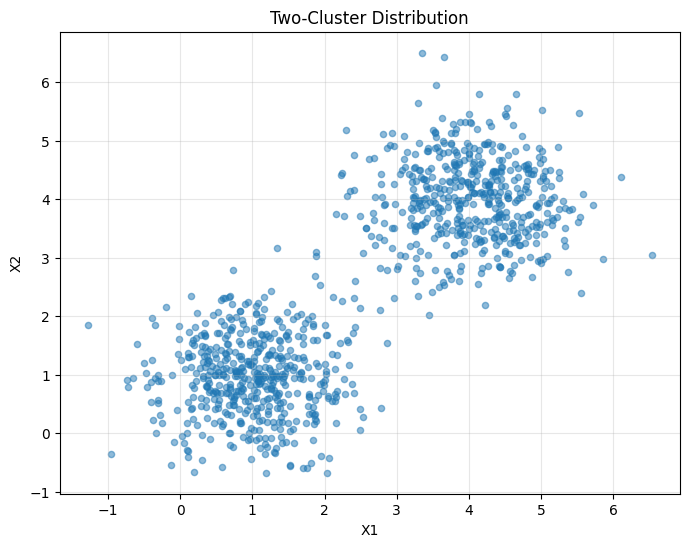

In [10]:
# Exercise workspace - try your experiments here!

# Example: Two-cluster distribution
def generate_two_cluster_samples(n_samples):
    """
    Generate samples from a mixture of two Gaussians.
    """
    # Half from first cluster
    n_half = n_samples // 2
    cluster1 = np.random.multivariate_normal([1, 1], [[0.5, 0], [0, 0.5]], n_half)
    cluster2 = np.random.multivariate_normal([4, 4], [[0.5, 0], [0, 0.5]], n_samples - n_half)
    return np.vstack([cluster1, cluster2])

# Visualize the new distribution
samples = generate_two_cluster_samples(1000)
plt.figure(figsize=(8, 6))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=20)
plt.title('Two-Cluster Distribution')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True, alpha=0.3)
plt.show()

# Now try training a GAN on this distribution!
# Hint: Replace generate_real_samples with generate_two_cluster_samples in the training loop

## Advanced GAN Architectures

The simple GAN we implemented is just the beginning. Many advanced variants have been developed:

### 1. Deep Convolutional GAN (DCGAN)
- Uses convolutional layers for image generation
- Introduced architectural guidelines for stable training
- Widely used for generating realistic images

### 2. Conditional GAN (cGAN)
- Allows conditioning generation on additional information (e.g., class labels)
- Both generator and discriminator receive conditional input
- Useful for controlled generation

### 3. Wasserstein GAN (WGAN)
- Uses Wasserstein distance instead of Jensen-Shannon divergence
- More stable training
- Better gradient behavior

### 4. StyleGAN
- State-of-the-art for high-resolution image generation
- Allows control over different levels of detail
- Used to generate photorealistic faces

### 5. CycleGAN
- Unpaired image-to-image translation
- Can transform images from one domain to another without paired examples
- Applications in style transfer, season change, etc.

## Real-World Applications of GANs

GANs have found numerous practical applications:

### 1. Image Generation and Synthesis
- Creating photorealistic images of faces, objects, scenes
- Generating artwork and designs
- Creating synthetic training data

### 2. Image Enhancement
- Super-resolution (enhancing image quality)
- Image inpainting (filling missing regions)
- Colorization of black and white images

### 3. Style Transfer
- Transferring artistic styles between images
- Converting photos to paintings
- Season and weather transformation

### 4. Data Augmentation
- Generating synthetic training examples for imbalanced datasets
- Creating variations of existing data
- Privacy-preserving synthetic data generation

### 5. Medical Imaging
- Generating synthetic medical images for training
- Image reconstruction and denoising
- Cross-modality image translation (e.g., MRI to CT)

### 6. Gaming and Entertainment
- Procedural content generation
- Character and environment design
- Animation and visual effects

## Key Takeaways

- **GANs consist of two competing networks**: A generator creates fake samples while a discriminator tries to distinguish real from fake samples.

- **Adversarial training is a minimax game**: The generator tries to minimize the discriminator's ability to classify samples correctly, while the discriminator tries to maximize it.

- **Training GANs can be challenging**: Common issues include mode collapse, vanishing gradients, and training instability. Careful architecture design and hyperparameter tuning are essential.

- **GANs learn data distributions**: Unlike discriminative models, GANs learn the underlying distribution of data and can generate new, realistic samples from that distribution.

- **Many advanced variants exist**: DCGANs for images, WGANs for stability, cGANs for conditional generation, and StyleGAN for high-quality image synthesis each address specific challenges and applications.

- **Wide range of applications**: From generating realistic images to data augmentation, style transfer, and beyond, GANs have transformed generative modeling and creative AI.

## Further Resources

### Original Papers
- [Generative Adversarial Networks (Goodfellow et al., 2014)](https://arxiv.org/abs/1406.2661) - The original GAN paper
- [Unsupervised Representation Learning with DCGANs (Radford et al., 2015)](https://arxiv.org/abs/1511.06434) - Deep Convolutional GANs
- [Wasserstein GAN (Arjovsky et al., 2017)](https://arxiv.org/abs/1701.07875) - WGAN for stable training

### Tutorials and Courses
- [TensorFlow GAN Tutorial](https://www.tensorflow.org/tutorials/generative/dcgan) - Official TensorFlow DCGAN tutorial
- [PyTorch GAN Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) - PyTorch implementation of DCGAN
- [Stanford CS231n: Generative Models](http://cs231n.stanford.edu/) - Lecture on generative models including GANs

### Advanced Topics
- [StyleGAN2 (Karras et al., 2020)](https://arxiv.org/abs/1912.04958) - State-of-the-art image generation
- [CycleGAN (Zhu et al., 2017)](https://arxiv.org/abs/1703.10593) - Unpaired image-to-image translation
- [Progressive Growing of GANs (Karras et al., 2017)](https://arxiv.org/abs/1710.10196) - Training GANs progressively

### Practical Resources
- [GAN Lab](https://poloclub.github.io/ganlab/) - Interactive visualization of GAN training
- [This Person Does Not Exist](https://thispersondoesnotexist.com/) - Examples of StyleGAN-generated faces
- [Papers With Code - GANs](https://paperswithcode.com/methods/category/generative-adversarial-networks) - Latest GAN research and code